# 識別のための形状正規化プログラム

- 微妙な凹凸は識別に関係ないので滑らかにする。
- サイズを正規化する
- スケルトン抽出してスケルトンの距離情報を作る。通常の距離は最短の黒画素までの距離として定義されるが、カバー率という概念を導入し、一定量（例えば９５％）の白画素が含まれる最大の距離を改めて距離と定義する。
- その距離範囲を白で塗りつぶした図形をあらためてシルエットとし、再度スケルトン抽出を行う。
- ハフ変換によりスケルトンの直線検出を行い、中心軸を定める。

これは１次近似。ベジエ曲線当てはめも試してみたい。

# 予備実験１

In [687]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os
import numpy as np
import cv2

UNIT =64
# https://www.piskelapp.com/p/agxzfnBpc2tlbC1hcHByEwsSBlBpc2tlbBiAgKDQzJChCQw/edit

# 形の整形ステップ１
def step1(imgfilename):
    print(imgfilename)
    src = cv2.imread(imgfilename,0)
    # 長辺が６４ピクセルになるよう縮小し、128x128の画像の中央に配置する。
    print(src.shape)
    h,w = src.shape[:2]
    u_l = w if w > h else h
    s_r = UNIT/w if w > h else UNIT/h
    rsh,rsw = int(s_r*h),int(s_r*w)
    x0 = int((128-rsw)/2)
    y0 = int((128-rsh)/2)
    img = np.zeros((128,128),np.uint8)
    img[y0:y0+rsh,x0:x0+rsw] = cv2.resize(src,(rsw,rsh))

    # 細かい凹凸を無くしたいので少しだけぼかして２値化
    blurimg = cv2.GaussianBlur(img,(15,15),0) 
    ret,thimg = cv2.threshold(blurimg,127,1,cv2.THRESH_BINARY) # 白画素は１にする
    #  1ピクセル幅の部分は厄介なので、１回だけ膨張させて幅１の部分は無くす
    # dilateimg = cv2.dilate(thimg,(3,3),iterations = 1)
    dilateimg = thimg #  
    # 孔が生じる可能性があるので、念のため、最外殻輪郭を取り出し、描きなおすことで孔を無くす
    _img,cnt,hierarchy = cv2.findContours(dilateimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.drawContours(dilateimg, cnt, 0, 255, thickness=-1)
    ret,thimg2 = cv2.threshold(img2,127,1,cv2.THRESH_BINARY)

    skeleton = skeletonize(thimg2)
    # 結果を出力します
    plt.subplot(231), plt.imshow(img[32:96,32:96], cmap='gray')
    plt.title("64x64 image")
    plt.subplot(232), plt.imshow(blurimg[32:96,32:96], cmap='gray')
    plt.title("blurmg image")
    plt.subplot(233), plt.imshow(thimg[32:96,32:96], cmap='gray')
    plt.title("first threshold image")
    plt.subplot(234), plt.imshow(dilateimg[32:96,32:96], cmap='gray')
    plt.title("dilate image")
    wimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    wimg = cv2.drawContours(wimg, cnt, 0, (255,0,0), thickness=1)
    plt.subplot(235), plt.imshow(wimg[32:96,32:96], cmap='gray')
    plt.title("closed image")
    plt.subplot(236), plt.imshow(skeleton[32:96,32:96], cmap='gray')
    plt.title("thinned image")
    plt.show()
    return skeleton[32:96,32:96],dilateimg[32:96,32:96]

testdots.png
(64, 64)


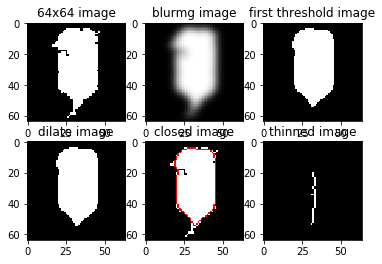

In [688]:
imgfilename = 'testdots.png'
skel,img = step1(imgfilename)

概形シルエット2/17Apically/17daruma6o06_l.jpg
(242, 140)


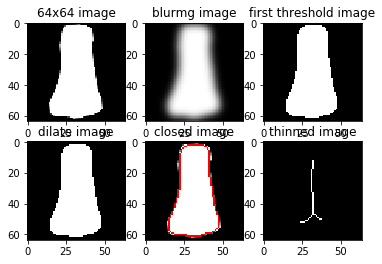

In [435]:
skel,img = step1('概形シルエット2/17Apically/17daruma6o06_l.jpg')

概形シルエット2/17Cylindric/17makoto1o06_l.jpg
(249, 105)


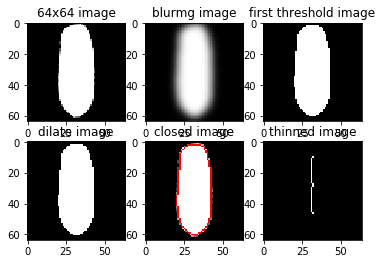

In [436]:
skel,img = step1('概形シルエット2/17Cylindric/17makoto1o06_l.jpg')

概形シルエット/17Tran_ellip/17karami2o03_l.jpg
(132, 137)


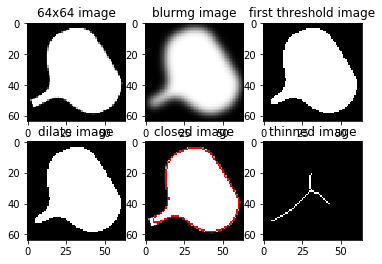

In [437]:
skel,img = step1('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

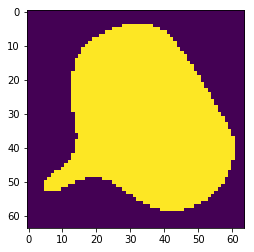

In [313]:
plt.imshow(img)

**skeleton(img) の結果は画像サイズと同じ配列で、値は True, False である**

予備実験１ここまで

# スケルトンを基にした形状補正

In [511]:
# skelton の各点について、次の式を満足する最大の値を求める。
#    その点を中心とする半径 r の円内に含まれる点の割合　　>=  criteria１
#    その点を中心として黒画素を含むことのない最大の円の半径を r1 とするとき、
#    その点を中心とする半径 r2 の領域内で、r1以遠の白画素の数が
#    r2 と r1 で挟まれたドーナツ型領域の面積に占める割合 >= creteria2

# (x,y)を中心とする外径r1の内径r2のドーナツ型に挟まれた白画素数とドーナツ型の画素数を返す
def circle_coverarea(img,y,x,r1,r2=0):
    # img 対象画像は GRAY画像であることが前提
    _ret,bw = cv2.threshold(img,0,1,cv2.THRESH_BINARY) # 白画素は１にする
    # 半径 r 1の円を描いたマスクイメージを作成
    maskimg = cv2.circle(np.zeros_like(bw), (x, y), r1, 1, -1)   
    if r2 > 0:
        maskimg = cv2.circle(maskimg, (x, y), r2, 0, -1)
    bw = cv2.bitwise_and(bw, bw, mask=maskimg) # マスクして重なりを求める
    return np.sum(bw),np.sum(maskimg)

def max_coverratio(img,skel,criteria1=0.9,criteria2=0.8):
    # 幅の上限を知るために、バウンダリボックスを得る
    _retval, _labels, stats, _centroids = cv2.connectedComponentsWithStats(img,connectivity=8)
    ln = 1 if stats[1][2]!=64 else 0  #  おそらく対象となる連結成分は１で間違いないが、念のためチェック
    #  縦と横のうち、小さい方の半分の半径まで調べれば十分
    limit = int(stats[ln][2]/2) if stats[ln][2]<stats[ln][3] else int(stats[ln][3]/2) 
    skstat = []
    for y in range(skel.shape[0]):
        for x in range(skel.shape[1]):
            if skel[y][x] : # スケルトンの画素かどうか
                # まず、カバレッジ１００％となる限界の半径を求める
                corearea = 0
                for r1 in range(1,limit):
                    area,carea = circle_coverarea(img,y,x,r1,r2=0)
                    if area != carea :
                        r1 = r1 -1
                        break
                    else:
                        corearea = area
                r2 = r1
                for r1 in range(r2+1,limit):
                    area,carea = circle_coverarea(img,y,x,r1,r2)
                    c1 = (area/carea >= criteria2)
                    c2 = ((area+corearea)/(carea+corearea) >= criteria1)
                    if c1 == False or c2 == False :
                        r1 = 0.5 if r1 == 1 else r1 - 1
                        break
                skstat.append([(y,x),r1])
    return skstat

概形シルエット/17Tran_ellip/17miniml1o04_l.jpg
(85, 79)


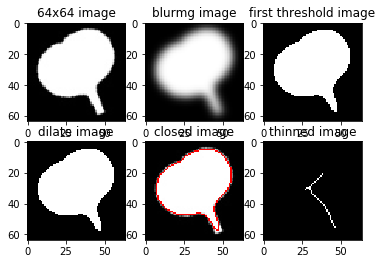

[[(21, 38), 16],
 [(22, 37), 16],
 [(23, 36), 17],
 [(24, 35), 17],
 [(25, 34), 17]]

In [514]:
skel,img = step1('概形シルエット/17Tran_ellip/17miniml1o04_l.jpg')
skstat = max_coverratio(img,skel,criteria1=1,criteria2=1)
skstat[:5]

skstat は　[(y,x),距離] のリストである。(x,y) はスケルトン画素の座標

Text(0.5,1,'new skeleton')

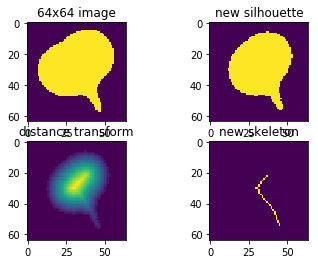

In [548]:
# 得られた skstat データを基にして形状を描きなおす
img2 = np.zeros((64,64),np.uint8)
for [(y,x),d] in skstat:
    cimg = np.zeros((64,64),np.uint8)
    cimg = cv2.circle(cimg,(x,y),int(d),1,-1)
    img2 = cv2.addWeighted(img2,1,cimg,1,0)
# ２値化して補正シルエットを得る。
_ret,img3 = cv2.threshold(img2,0,1,cv2.THRESH_BINARY)
# あらためて細線化スケルトンを得る
skeleton = skeletonize(img3)
# (確認のためにだけ）補正図形に対して厳密なユークリッド距離による距離データを作成
dst = cv2.distanceTransform(img3,cv2.DIST_L2,5)

plt.subplot(221), plt.imshow(img)
plt.title("64x64 image")
plt.subplot(222), plt.imshow(img3)
plt.title("new silhouette")
plt.subplot(223), plt.imshow(dst)
plt.title("distance transform")
plt.subplot(224), plt.imshow(skeleton)
plt.title("new skeleton")


In [484]:
type(skeleton)

numpy.ndarray

In [ ]:
import os

# この関数は画像の入った複数のフォルダが１つのフォルダに入っていることを前提としている。
#  指定フォルダ直下の画像ファイルは無視する。直下のフォルダの中しか見ず、さらにサブフォルダがあっても再帰的に探すようなことはしない。

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))

# 距離データ

In [290]:
skstat = max_coverratio(img,skel,32,10,criteria1=1,criteria2=1)

# 距離データを明るさとしてプロットしてみるとこんな感じ

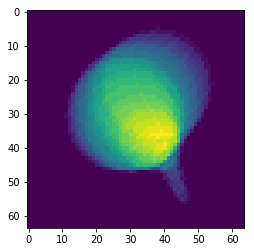

In [516]:
img2 = np.zeros((64,64),np.uint8)
for [(y,x),d] in skstat:
    cimg = np.zeros((64,64),np.uint8)
    cimg = cv2.circle(cimg,(x,y),int(d),1,-1)
    img2 = cv2.addWeighted(img2,1,cimg,1,0)
_ret,img3 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY)
dst = cv2.distanceTransform(img3,cv2.DIST_L2,3)
for index,[(y,x),d] in enumerate(skstat):    
    skstat[index][1] = dst[y,x]
plt.imshow(img2)

これは重ねて書いただけなので、距離画像ではない。

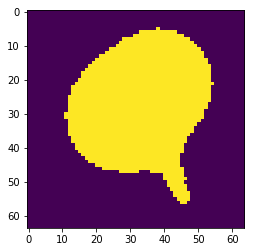

In [517]:
_ret,img3 = cv2.threshold(dst,0,255,cv2.THRESH_BINARY)
plt.imshow(img3)

# スケルトン点列を直線フィッティングしてみる。

(-521, -853) (538, 842)


'cv2.imshow("ABC",color)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)'

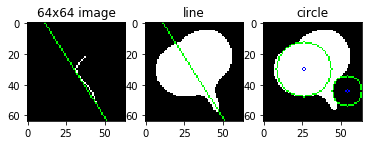

In [684]:

# img2 = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

skgray = 255*np.array(skeleton,np.uint8)
# rskgray = cv2.resize(skgray,(64,64))
color = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
scolor = cv2.cvtColor(skgray,cv2.COLOR_GRAY2BGR)

# blurimg = cv2.GaussianBlur(rskgray,(33,33),0) 
ret,rsskel2 = cv2.threshold(rskgray,1,255,cv2.THRESH_BINARY)
# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)

lines = cv2.HoughLines(rsskel2,1,np.pi/180,1)
minLineLength = 10
maxLineGap = 5
# lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
# for [[x1,y1,x2,y2]] in lines:
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(scolor,(x1,y1),(x2,y2),(0,255,0),1)
        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),1)
        
        #cv2.line(color,(x1,y1),(x2,y2),(0,0,255),2)
        print((x1,y1),(x2,y2))

mimg = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(mimg,cv2.COLOR_GRAY2BGR)

circles = cv2.HoughCircles(mimg,cv2.HOUGH_GRADIENT,1,30,
# circles = cv2.HoughCircles(rsskel2,cv2.HOUGH_GRADIENT,1,30,
                            param1=20,param2=10,minRadius=5,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),1,(0,0,255),1)
        
plt.subplot(131), plt.imshow(scolor)
plt.title("64x64 image")
plt.subplot(132), plt.imshow(color)
plt.title("line")
plt.subplot(133), plt.imshow(cimg)
plt.title("circle")

'''cv2.imshow("ABC",color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)'''

In [518]:
import sys
import tensorflow as tf

x_data = np.array([x for [(y,x),d] in skstat]).astype(np.float32)
y_data = np.array([y for [(y,x),d] in skstat]).astype(np.float32)
w_data = np.array([d for [(y,x),d] in skstat]).astype(np.float32)

In [641]:
circles

In [65]:
y_data

array([2.40342  , 3.427387 , 4.721916 , 4.586968 , 3.2442274, 4.830287 ,
       4.9496   , 3.6165261, 3.974512 , 2.8711152], dtype=float32)

In [ ]:
 = [[1.],[5.]]
input_y = [[4.],[2.]]

x = tf.placeholder("float", [None, 1])
y_ = tf.placeholder("float", [None, 1])

a = tf.Variable([1.], name="slope")
b = tf.Variable([0.], name="y-intercept")
y = tf.multiply(a, x) + b

init = tf.global_variables_initializer()

# 誤差関数
loss = tf.reduce_sum(tf.square(y_ - y))

# トレーニング方法は、勾配降下法を選択
train_step = tf.train.GradientDescentOptimizer(0.03).minimize(loss)


with tf.Session() as sess:
    sess.run(init)
    print('初期状態')
    print('誤差' + str(sess.run(loss, feed_dict={x_: input_x, y_: input_y, w_:input})))
    print("slope: %f, y-intercept: %f" % (sess.run(a), sess.run(b)))

    for step in range(100):
        sess.run(train_step, feed_dict={x: input_x, y_: input_y})
        if (step+1) % 20 == 0:
            print('\nStep: %s' % (step+1))
            print('誤差' + str(sess.run(loss, feed_dict={x: input_x, y_: input_y})))
            print("slope: %f, y-intercept: %f" % (sess.run(a), sess.run(b)))
#
sys.stderr.write("*** end ***\n")

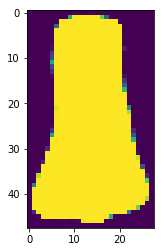

In [408]:
skeleton.shape
plt.imshow(img)

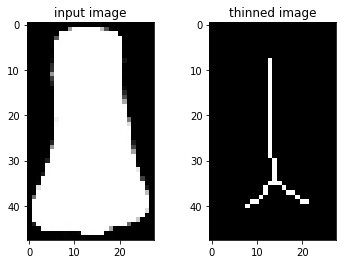

In [385]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os

img = cv2.imread('概形シルエット/17Apically/17daruma6o06_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

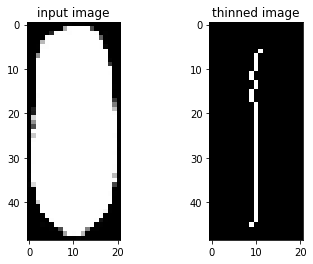

In [92]:
img = cv2.imread('概形シルエット/17Cylindric/17makoto1o06_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

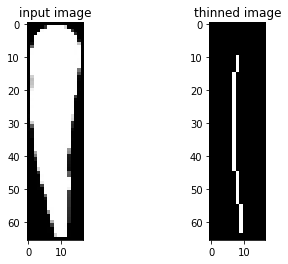

In [93]:
img = cv2.imread('概形シルエット/17Triagular/17horyou1o05_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

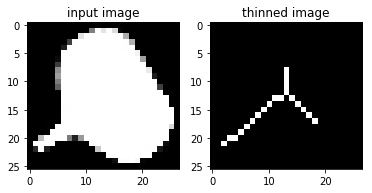

In [426]:
img  = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg',0)
img = cv2.resize(img,(int(img.shape[1]/5),int(img.shape[0]/5)))
ret,th2 = cv2.threshold(img,127,1,cv2.THRESH_BINARY)

skeleton = skeletonize(th2)
# 結果を出力します
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title("input image")
plt.subplot(122), plt.imshow(skeleton, cmap='gray')
plt.title("thinned image")
plt.show()

In [429]:
# メインプログラム
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os

def batch(images, savedir='スケルトン',normalize=False,interactive = True):
    # savedir 保存先
    # interactive 結果を１枚ずつ確認するかどうか
    global skeleton,img,wimg
    
    for path in images:
        # print(path)
        
        src = cv2.imread(path,0) # 対象画像の読み込み
        
        if normalize:
            # 処理対象画像を　短辺６４に正規化する
            height, width = src.shape[:2]
            nlen = width if width < height else height # 縦横の短い方
            shrink = 64/nlen # 縮小率
            src = cv2.resize(src,(int(shrink*width),int(shrink*height)))
        
        # ２値化するとともに、白を１にする
        _ret,img = cv2.threshold(src,127,1,cv2.THRESH_BINARY)
        
        # scikit-learn の高速細線化処理を適用
        skeleton = np.array(255*skeletonize(img),dtype=np.uint8)
        
        # 端点を抽出
        _img,cnt,hierarchy = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        wimg = np.zeros(img.shape,np.uint8)
        wimg = cv2.drawContours(wimg, [cnt[0]], -1, 255, 1)
        print(set(tuple(cnt[0])))
                                

        # 結果を確認       
        if interactive:
            cv2.imshow(path,mkparaimage(cv2.bitwise_xor(src,img),skeleton))
            key = cv2.waitKey(0)
            cv2.destroyAllWindows()
            cv2.waitKey(1) 
            if key == 113: #  "Q" で終了する
                break
                
def neighbours(x, y, image):
    return [image[x-1][y], image[x-1][y+1], image[x][y+1], image[x+1][y+1], 
             image[x+1][y], image[x+1][y-1], image[x][y-1], image[x-1][y-1]]

def isterminal(x,y,image):
    return sum(neighbours(x,y,image))

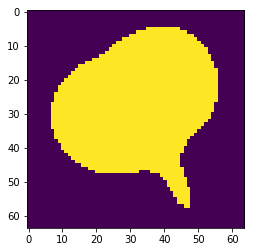

In [547]:
plt.imshow(img)
wimg = np.copy(img)

In [582]:
sskel=255*skel.astype(np.uint8)
cv2.imshow("AB C",edges)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [633]:
import cv2
import numpy as np

# img2 = cv2.imread('概形シルエット/17Tran_ellip/17karami2o03_l.jpg')

skgray = 255*np.array(skeleton,np.uint8)
# rskgray = cv2.resize(skgray,(64,64))
color = cv2.cvtColor(skgray,cv2.COLOR_GRAY2BGR)
# blurimg = cv2.GaussianBlur(rskgray,(33,33),0) 
ret,rsskel2 = cv2.threshold(rskgray,1,255,cv2.THRESH_BINARY)
# edges = cv2.Canny(rsskel2,50,150,apertureSize = 3)

lines = cv2.HoughLines(rsskel2,1,np.pi/180,1)
minLineLength = 10
maxLineGap = 5
# lines = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
# for [[x1,y1,x2,y2]] in lines:
for [rho,theta] in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(color,(x1,y1),(x2,y2),(0,255,0),2)
        
        # cv2.line(color,(x1,y1),(x2,y2),(0,0,255),2)
        print((x1,y1),(x2,y2))

cv2.imshow("ABC",color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

(-521, -853) (538, 842)


-1

In [621]:
lines[0]

array([[-37.       ,   2.5132742]], dtype=float32)